<a href="https://colab.research.google.com/github/Mizuki-OHASHI/notebooks/blob/main/reservoir_computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install reservoirpy

  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.8 MB/s eta 0:00:00


### サンプルコードで動作確認

- pip のサンプルコードでエラーなく動くかどうか確認
- fetched from https://pypi.org/project/reservoirpy/


In [ ]:
from reservoirpy.datasets import mackey_glass, to_forecasting
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.observables import rmse, rsquare

### Step 1: Load the dataset

X = mackey_glass(n_timesteps=2000)  # (2000, 1)-shaped array
# create y by shifting X, and train/test split
x_train, x_test, y_train, y_test = to_forecasting(X, test_size=0.2)

### Step 2: Create an Echo State Network

# 100 neurons reservoir, spectral radius = 1.25, leak rate = 0.3
reservoir = Reservoir(units=100, sr=1.25, lr=0.3)
# feed-forward layer of neurons, trained with L2-regularization
readout = Ridge(ridge=1e-5)
# connect the two nodes
esn = reservoir >> readout

### Step 3: Fit, run and evaluate the ESN

esn.fit(x_train, y_train, warmup=100)
predictions = esn.run(x_test)

print(f"RMSE: {rmse(y_test, predictions)}; R^2 score: {rsquare(y_test, predictions)}")
# RMSE: 0.0020282; R^2 score: 0.99992

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-0: 487it [00:00, 4866.25it/s]           
Running Model-0: 974it [00:00, 3473.07it/s]
Running Model-0: 1599it [00:00, 3787.70it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Fitting node Ridge-0...


Running Model-0: 400it [00:00, 6530.36it/s]           

RMSE: 0.0025013116442207848; R^2 score: 0.9998728929224348


### 記事の再現 (東京の気温)

- 東京の気温を題材としたQiitaの実装例「リザバーコンピューティング概観」を再現してみる
- fetched from https://qiita.com/masaka_programming/items/4ce659f5e093ede9a0a4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [ ]:
# データセットのダウンロードと可視化
data_src = "https://www.salesanalytics.co.jp/5kf2"
X_df = pd.read_csv(data_src, index_col=0)

======================== データの確認 ========================


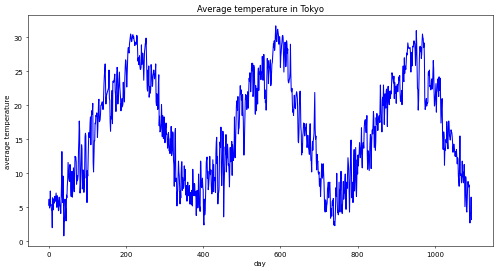

[(765, 1), (765, 1), (327, 1), (327, 1)]


Running Model-157:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-157: 765it [00:00, 4221.63it/s]
Running Model-157: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Fitting node Ridge-157...


Running Model-157: 327it [00:00, 4275.49it/s]           


======================== 予測結果 ========================


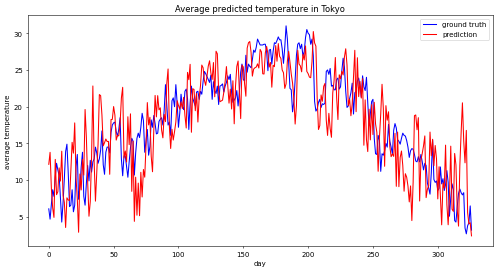

In [ ]:
X = np.array(X_df.values)
fig = plt.figure(figsize=(12, 6), dpi=50)
ax = plt.axes()
ax.plot(X, "b-")
ax.set_xlabel("day")
ax.set_ylabel("average temperature")
ax.set_title("Average temperature in Tokyo")
print("="*24+" データの確認 "+"="*24)
plt.show()

# 訓練データとテストデータの作成

# 前半7割を訓練用、後半3割をテスト用に使う
train = X[:int(len(X)*0.7)]
test = X[int(len(X)*0.7):]
# N日後の平均気温を目標値とする
N = 2
x_train = train[:-N]
y_train = train[N:]
x_test = test[:-N]
y_test = test[N:]

print(list(arr.shape for arr in [x_train, y_train, x_test, y_test]))

# ESNモデルの訓練
# easyesn がインストールできず, 他のパッケージを使うことにしたので, ここが Qiita の記事と違うところ

# 100 neurons reservoir, spectral radius = 1.25, leak rate = 0.3
reservoir = Reservoir(units=100, sr=15, lr=0.75, seed=42) # sr は入出力のスケールと同程度にするとよさそう
# feed-forward layer of neurons, trained with L2-regularization (リッジ回帰)
readout = Ridge(ridge=1e-5)
# connect the two nodes
esn = reservoir >> readout

esn.fit(x_train, y_train, warmup=365) # warmup は周期と同じにすることが多いらしい

# 予測結果
y_test_pred = esn.run(x_test)

fig = plt.figure(figsize=(12, 6), dpi=50)
ax = plt.axes()
ax.plot(y_test, "b-", label="ground truth")
ax.plot(y_test_pred, "r-", label="prediction")
ax.set_xlabel("day")
ax.set_ylabel("average temperature")
ax.set_title("Average predicted temperature in Tokyo")
ax.legend()
print("="*24+" 予測結果 "+"="*24)
plt.show()

### 他のデータセットでやってみる (CO$_2$濃度)

- Mauna Loa Weekly Atmospheric CO2 Data
- データの説明: https://arc.net/l/quote/bblnxrtn

In [250]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True)
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


In [251]:
import polars as pl

co2_data = pl.DataFrame(co2.frame[["year", "month", "day", "co2"]]).select(
    pl.date("year", "month", "day"), "co2"
)
co2_data.head()

date,co2
date,f64
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


[(2225, 1), (2173, 1)]
======================== データの確認 ========================


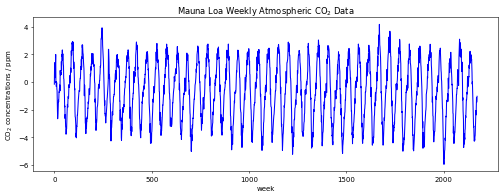

[(1519, 1), (1519, 1), (650, 1), (650, 1)]


Running Model-175:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-175: 415it [00:00, 4143.02it/s]           
Running Model-175: 831it [00:00, 4123.60it/s]
Running Model-175: 1519it [00:00, 3996.92it/s]
Running Model-175: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Fitting node Ridge-175...


Running Model-175: 650it [00:00, 3497.76it/s]


======================== 予測結果 ========================


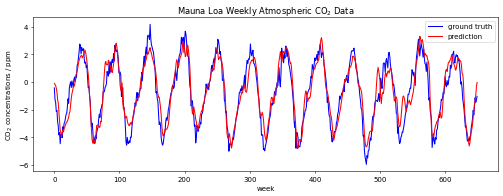

In [281]:
X_co2 = co2_data["co2"].to_numpy().reshape((-1, 1))
# 1ずつずらしながら 365//7 要素の平均をとる
X_co2_trend = np.array([X_co2[i:i+365//7].mean() for i in range(len(X_co2)-365//7)]).reshape((-1, 1))
print(list(arr.shape for arr in [X_co2, X_co2_trend]))
# X_co2 = np.concatenate([ X_co2_trend, X_co2[:len(X_co2)-365//7]-X_co2_trend], axis=1)
X_co2 = X_co2[:len(X_co2)-365//7]-X_co2_trend # トレンド成分の削除

fig = plt.figure(figsize=(12, 4), dpi=50)
ax = plt.axes()
ax.plot(X_co2, "b-")
ax.set_xlabel("week")
ax.set_ylabel("CO$_2$ concentrations / ppm")
ax.set_title("Mauna Loa Weekly Atmospheric CO$_2$ Data")
print("="*24+" データの確認 "+"="*24)
plt.show()

# # 訓練データとテストデータの作成

# 前半7割を訓練用、後半3割をテスト用に使う
train = X_co2[:int(len(X_co2)*0.7)]
test = X_co2[int(len(X_co2)*0.7):]
# N週後の平均濃度を目標値とする
N = 2
x_train = train[:-N]
y_train = train[N:]
x_test = test[:-N]
y_test = test[N:]

print(list(arr.shape for arr in [x_train, y_train, x_test, y_test]))

# ESNモデルの訓練

# 100 neurons reservoir, spectral radius = 1.25, leak rate = 0.3
reservoir = Reservoir(units=100, sr=5, lr=0.3, seed=42) # sr は入出力のスケールと同程度にするとよさそう
# feed-forward layer of neurons, trained with L2-regularization (リッジ回帰)
readout = Ridge(ridge=1e-3)
# connect the two nodes
esn = reservoir >> readout

esn.fit(x_train, y_train, warmup=365//7) # warmup は周期と同じにすることが多いらしい

# 予測結果
y_test_pred = esn.run(x_test)

fig = plt.figure(figsize=(12, 4), dpi=50)
ax = plt.axes()
ax.plot(y_test, "b-", label="ground truth")
ax.plot(y_test_pred, "r-", label="prediction")
ax.set_xlabel("week")
ax.set_ylabel("CO$_2$ concentrations / ppm")
ax.set_title("Mauna Loa Weekly Atmospheric CO$_2$ Data")
ax.legend()
print("="*24+" 予測結果 "+"="*24)
plt.show()